<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Time Series: Forecasting Models

# Installing StatsModels

The default `statsmodels` installation you get with Anaconda doesn't include some of the time series modeling components. Run the following cell to see if you need to install these components.

In [1]:
from statsmodels.tsa.api import ExponentialSmoothing

If you get an error, try running this command:

In [2]:
!pip install -U statsmodels

Requirement already up-to-date: statsmodels in /Users/gGandenberger/anaconda3/envs/py37/lib/python3.7/site-packages (0.9.0)
mkl-random 1.0.1 requires cython, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Now reset your kernel and try again.

If it still doesn't work, just sit tight for this lesson. Check out [this page](http://www.statsmodels.org/stable/install.html) later if you want to use the statsmodels extensions for time series forecasting.

# Time Series Models

**Time series analysis** comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. (The analyses we've been doing in previous section qualify as time series analysis).

**Time series forecasting** is the use of a model to predict future values based on previously observed values.

- Time series forecasting models predict a future value in a time series. Like other predictive models, we will use prior history to predict the future. Unlike previous models, however, we will use the _outcome_ variables from earlier in time as the _inputs_ for prediction.
- As with the modeling you're used to, we will have to evaluate different models on _test data_ to ensure that we have chosen the best one.

# Properties of Time Series Forecasting Models

## Training and Testing Sets

Because these data are ordered, we **cannot choose training and testing examples at random.** As we are attempting to predict _a sequence of future values_, we must train on values from earlier (in time) in our data and then test our values at the end of the period.

## Moving Averages and Autocorrelation

In previous sections, we learned about a few statistics for analyzing time series. A **moving average** is the average of *k* surrounding data points in time.

We also looked at autocorrelation the compute the relationship of the data with prior values.

**Autocorrelation** is how correlated a variable is with itself. Specifically, how related variables from earlier in time are with variables from later in time. Note the need for a mean value:

${\Huge R(k) = \frac{\operatorname{E}[(X_{t} - \mu)(X_{t-k} - \mu)]}{\sigma^2}}^*$

## Stationarity

The criteria for classifying a series as stationary indicate that:

* The mean of the series should not be a function of time, but rather should be a constant. The image below has the left-hand graph satisfying this condition, whereas the graph in red has a time-dependent mean.

![](../assets/images/Mean_nonstationary.png)

* The variance of the series should not be a function of time. This property is known as homoscedasticity. The following graph depicts what is and what is not a stationary series. (Notice the varying spread of distribution in the right-hand graph.)

![](../assets/images/Var_nonstationary.png)

* The covariance of the `i`th term and the `(i + m)`th term should not be a function of time. In the following graph, you'll notice that the spread becomes closer as time increases. Hence, the covariance is not constant with time for the "red series."

![](../assets/images/Cov_nonstationary.png)

**Many time series models work on the assumption that the time series is stationary,** but real-world data often violate this assumption. For example, typical stock market performance is not stationary. In this plot of Dow Jones performance since 1986, the mean is clearly increasing over time:

![](../assets/images/dow-jones.png)

## Checking for Stationarity

In [3]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels as sm

In [4]:
drones = pd.read_csv('../assets/data/gt_drone_racing.csv', header=1)
drones.columns = ['week', 'drone_racing_interest']
drones.head()

,week,drone_racing_interest
0,2014-11-09,2
1,2014-11-16,2
2,2014-11-23,4
3,2014-11-30,6
4,2014-12-07,7


In [5]:
# Change the `week` column to a `datetime` object and make it the index of the DataFrame.
# /scrub/
drones.loc[:, 'week'] = pd.to_datetime(drones.loc[:, 'week'])
drones.set_index('week', inplace=True)
drones.head()

,drone_racing_interest
week,
2014-11-09,2
2014-11-16,2
2014-11-23,4
2014-11-30,6
2014-12-07,7


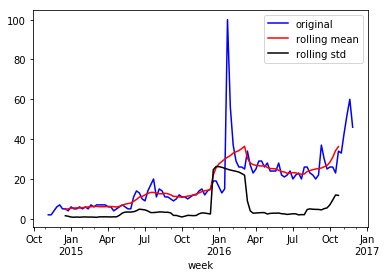

In [9]:
# Plot the data with the rolling mean and std
# /scrub/
ax = drones.plot(c='b')
rolmean.plot(c='r', ax=ax)
rolstd.plot(c='k', ax=ax)

ax.legend(['original', 'rolling mean', 'rolling std']);

The standard deviation experiences one jump, and the mean is increasing with time, so this time series appears not to be stationary.

## Making a Time Series Stationary

There are methods to transform a non-stationary time series into a stationary time series. One can then model the derived stationary time series, and perhaps then invert the transformation to generate a model of the original time series.

We will look specifically at removing a trend from a time series through **detrending** and **differencing**.

### Detrending

**Detrending** removes major trends in our data. The simplest way is to fit a line to the trend, then make a new series of the difference between the line and the true series. 

Below are U.S. housing prices over time that demonstrate an upward trend. This makes the time series non-stationary, as the mean home price is increasing. The line fit through it represents the trend.

The bottom figure is the "detrended" data, where each data point is transformed by subtracting the value of the trend line at that point. This data now have a fixed mean and may be easier to model. This is similar to mean-scaling our features in earlier models with `StandardScaler`.

![](../assets/images/detrend.gif)

#### Example: Detrending

In [13]:
# Fit a trendline to the data.
# /scrub/
row_nums = range(len(drones))
row_nums = np.reshape(row_nums, newshape=(-1, 1))

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(row_nums, drones.loc[:, 'drone_racing_interest'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [14]:
# Use the model to create the trendline as a series
# /scrub/
line = row_nums * lr.coef_[0] + lr.intercept_

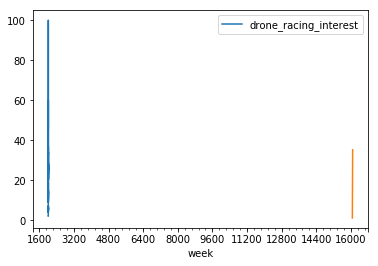

In [15]:
# Plot the trendline with the data
# /scrub/
ax = drones.plot()
ax.plot(drones.index, line);

Detrend the time series. In its simplest form, we literally subtract the trendline from the time series.

In [16]:
# Create the detrended series
# /scrub/
drones_detrended = drones.loc[:, 'drone_racing_interest'] - line.reshape(-1)
drones_detrended.head()

week
2014-11-09    0.868502
2014-11-16    0.550087
2014-11-23    2.231673
2014-11-30    3.913258
2014-12-07    4.594844
Name: drone_racing_interest, dtype: float64

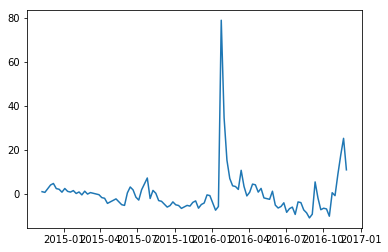

In [17]:
# Plot the detrended series
# /scrub/
fig, ax = plt.subplots()
ax.plot(drones.index, drones_detrended);

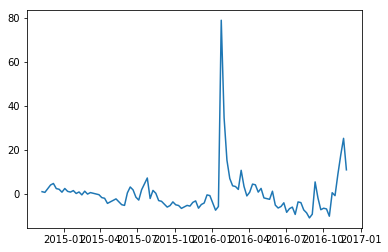

In [18]:
# Alternative approach: use the `detrend` function from `scipy`
# /scrub/
import scipy
drones_detrended2 = scipy.signal.detrend(drones.loc[:, 'drone_racing_interest'])

fig, ax = plt.subplots()
ax.plot(drones.index, drones_detrended2);

### Differencing

A related method is **differencing**. Instead of predicting the (non-stationary) series, we can predict the difference between two consecutive values. **ARIMA** models incorporate this approach.

Recall that we used Pandas' `.diff()` method to find the difference in an earlier section.

#### Example: Differencing

In [19]:
# Create the differenced series
# /scrub/
drones.loc[:, 'change'] = drones.loc[:, 'drone_racing_interest'].diff(1);
drones.head()

,drone_racing_interest,change
week,,
2014-11-09,2,NaN
2014-11-16,2,0.0
2014-11-23,4,2.0
2014-11-30,6,2.0
2014-12-07,7,1.0


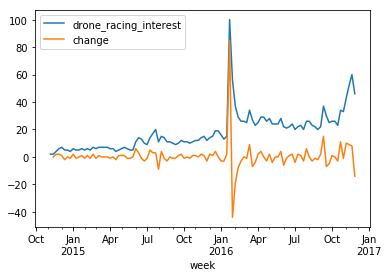

In [20]:
# Plot the differenced series
# /scrub/
ax = drones.plot();

# Time Series Forecasting Methods

## Method 1: Carry forward last observation

Let's look at Walmart's weekly sales data over a two-year period from 2010 to 2012. The data set is separated by store and department, but we'll focus on analyzing one store for simplicity.

In [21]:
# Load the data with "Date" as a DatetimeIndex
# /scrub/
walmart = pd.read_csv('../assets/data/train.csv', index_col='Date', parse_dates=True)
walmart.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


#### Filter the DataFrame to Store 1 sales and aggregate over departments to compute the total sales per store.

In [22]:
# Pull out Store 1
# /scrub/
store1 = walmart.loc[walmart.loc[:, 'Store'] == 1, :]

In [23]:
# Sum sales across departments
# /scrub/
store1_sales = store1.loc[:, 'Weekly_Sales'].groupby(store1.index).sum()

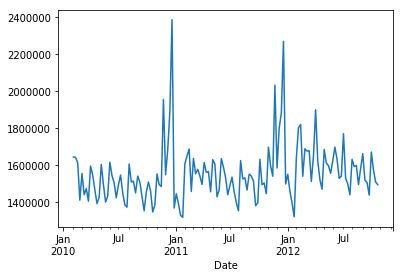

In [24]:
# Plot store 1 sales
# /scrub/
ax = store1_sales.plot()

One very simple forecasting method is to "carry forward" the last observation:

$$\hat y_{t+1} = y_t$$

We'll use the first two years (2010–2011) as the "training" data and the last year (2012) as a "testing" set.

In [25]:
# Split Store 1 Sales into train and test
# /scrub/
train = store1_sales.loc['2010': '2011']
test = store1_sales.loc['2012']

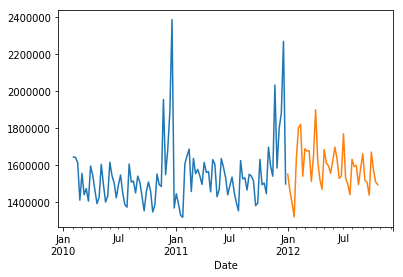

In [26]:
# Plot train and test
# /scrub/
ax = train.plot()
test.plot(ax=ax);

#### Let's see how the well the carry-forward method does when forecasting sales.

In [27]:
# Create series of carry-forward predictions, using a function for reusability
# /scrub/
def make_predictions(pred_func):
    predictions = np.zeros(test.shape) + pred_func(train)
    return pd.Series(predictions, index=test.index)

yhat_carry_forward = make_predictions(lambda train: train[-1])

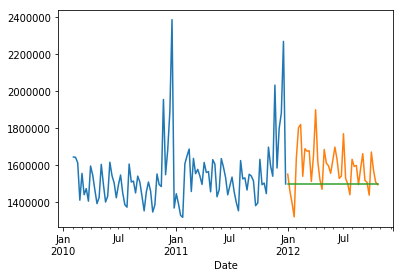

In [28]:
# Plot carry-forward predictions with train and test, again using a function
# /scrub/
def plot_predictions(predictions):
    ax = train.plot()
    test.plot(ax=ax)
    predictions.plot(ax=ax)
    
plot_predictions(yhat_carry_forward)

In [29]:
# Use RMSE to check the accuracy of our model on the test data set, again using a function
# /scrub/
from sklearn import metrics

def calculate_rmse(predictions):
    return np.sqrt(metrics.mean_squared_error(test, predictions))

calculate_rmse(yhat_carry_forward)

144192.4921506529

The carry-forward method is best suited for stable data sets without trend or seasonality, and its accuracy can depend greatly on where you happened to cut off the time series for training.

In addition to making predictons over the entire test set in one shot, we can also consider shorter-term predictions make on a rolling basis.

136617.39860411992

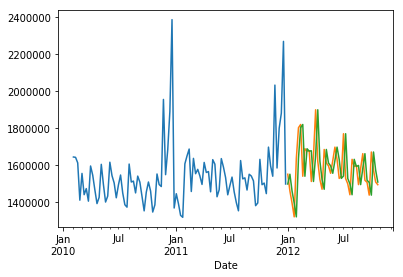

In [30]:
# Create series of rolling carry-forward predictions, again using a function
# /scrub/
def make_predictions_rolling(pred_func):
    predictions = []
    for index in range(len(test)):
        train_set = train.append(test[:index])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            predictions.append(pred_func(train_set))
    return pd.Series(np.array(predictions), index=test.index)

yhat_carry_forward_rolling = make_predictions_rolling(lambda train: train[-1])
plot_predictions(yhat_carry_forward_rolling)
calculate_rmse(yhat_carry_forward_rolling)

## Method 2: Simple Average

Simple average forecasts the weekly sales of the next time period to be the average of the sales over all previous time periods. 

$$\hat y_{t+1} = \dfrac{1}{x} \sum_{i=1}^{x} y_i$$

This method is less sensitive than carry-forward approach to where the training data is cut off. Like that approach, it does not capture seasonality, and it loses accuracy over time when there is a trend.

121981.78781090611

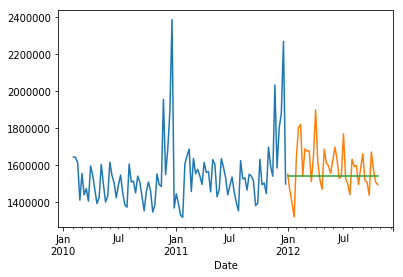

In [31]:
# Make predictions, plot them, get RMSE
# /scrub/
yhat_ave = make_predictions(np.mean)
plot_predictions(yhat_ave)
calculate_rmse(yhat_ave)

120090.01905303255

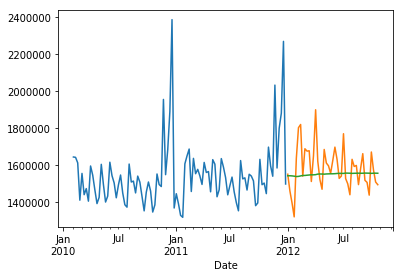

In [32]:
# Make rolling predictions, plot them, get RMSE
# /scrub/
yhat_ave_rolling = make_predictions_rolling(np.mean)
plot_predictions(yhat_ave_rolling)
calculate_rmse(yhat_ave_rolling)

This model improved the score a bit. The simple average method works best when the average at each time period remains constant.

## Method 3: Moving Average

When we have data sets in which the sales/value has increased or decreased sharply some time periods ago, simply using the previous average of all of the data (like the simple average method) isn't appropriate. An improvement over the simple average in this case will only take the average of the sales for the last few time periods, as we are think that only recent values may matter. This is called the **moving average** technique and it uses a sliding time period window to calculate the average. 

Using a simple moving average model, we forecast the next value(s) in a time series based on the average of a fixed finite number (`p`) of the previous values. Thus, for all `i > p`:

$$\hat y_{t+1} = \dfrac{1}{p} (y_{i-1} + y_{i-2} + y_{i-3} + ... + y_{i-p})$$

220538.43986419897

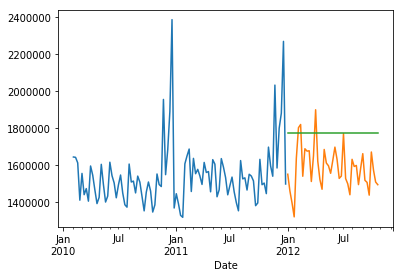

In [33]:
# Make predictions, plot them, get RMSE
# /scrub/
p = 8
yhat_moving_ave = make_predictions(lambda train: np.mean(train[-p:]))
plot_predictions(yhat_moving_ave)
calculate_rmse(yhat_moving_ave)

138212.5629182916

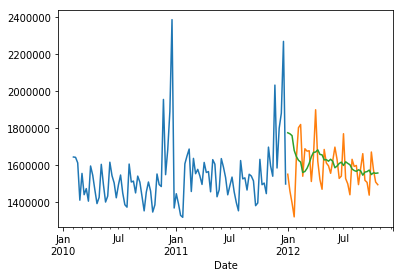

In [34]:
# Make rolling predictions, plot them, get RMSE
# /scrub/
p = 8
yhat_moving_ave_rolling = make_predictions_rolling(lambda train: np.mean(train[-p:]))
plot_predictions(yhat_moving_ave_rolling)
calculate_rmse(yhat_moving_ave_rolling)

This approach didn't perform very well in this case, because the last eight observations were from the busy holiday period.

## Method 4: Simple Exponential Smoothing 

Simple average and weighted moving average lie on opposite sides of the spectrum. **Simple exponential smoothing** lies between these two extremes and takes into account all of the data while weighing the data points differently. Simple exponential smoothing will calculate the forecast using weighted averages where the weights decrease exponentially as observations come from further in the past (the closet data points in time are weighted more heavily). 

$$\hat y_{t+1} = \alpha y_t + \alpha (1-\alpha)y_{t-1} + (1-\alpha)^2 y_{t-2} + ...$$

The one-step-ahead forecast for time `t+1` is a weighted average of all of the observations in the series (`y1,…,yt`). The rate at which the weights decrease is controlled by the parameter, `α` (which is between 0 and 1).

/Users/gGandenberger/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


231169.99953895088

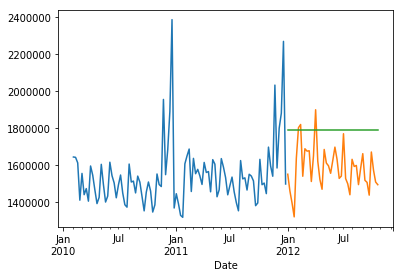

In [35]:
# Make predictions, plot them, get RMSE
# /scrub/
exp = sm.tsa.api.SimpleExpSmoothing(train).fit(smoothing_level=.3)
yhat_exp = exp.forecast(len(test))
plot_predictions(yhat_exp)
calculate_rmse(yhat_exp)

132537.0609841047

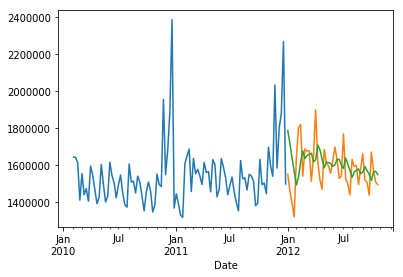

In [36]:
# Make rolling predictions, plot them, get RMSE
# /scrub/
yhat_exp_rolling = make_predictions_rolling(
    lambda train: sm.tsa.api.SimpleExpSmoothing(train).fit(smoothing_level=.3).forecast(1)[0]
)
plot_predictions(yhat_exp_rolling)
calculate_rmse(yhat_exp_rolling)

## Method 5: Holt's Linear Trend

The methods we've looked at so far don't do well when our data have high variations. If our data contain a trend, none of the previous methods would be able to take that into account. A method that can is **Holt's linear trend** method. 

Recall that a time series data set can be decomposed into its trend, seasonality, and residual components. If the data set contains a trend, then Holt's linear trend method can be applied. 

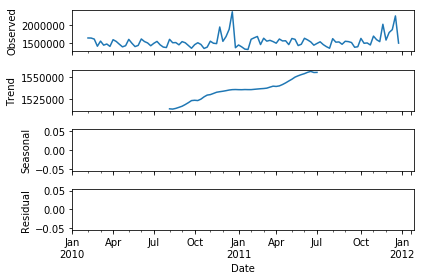

In [37]:
# Get decomposition
# /scrub/
fig = sm.tsa.api.seasonal_decompose(train).plot();

From these graphs, we can see that the data set follows an increasing trend, and we can use Holt's method to forecast the future sales.

Holt's method uses exponential smoothing to estimate both the average value of the series (called "level") and the trend. 

When the trend is linear, we add the estimated level and the estimated trend for forecasting. When the trend is exponential, we multiply them instead.

/Users/gGandenberger/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


781856.6060260109

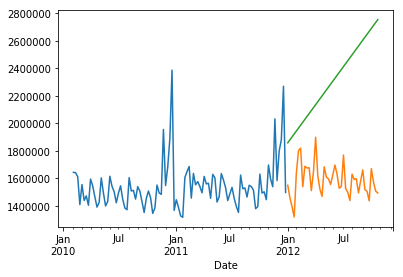

In [38]:
# Make predictions, plot them, get RMSE
# /scrub/
holt = sm.tsa.api.Holt(train).fit(smoothing_level=0.3, smoothing_slope=0.1)
yhat_holt = holt.forecast(len(test))
plot_predictions(yhat_holt)
calculate_rmse(yhat_holt)

133264.0849835261

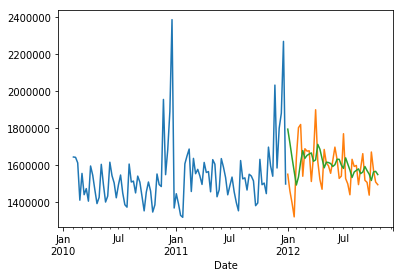

In [39]:
# Make rolling predictions, plot them, get RMSE
# /scrub/
yhat_holt_rolling = make_predictions_rolling(
    lambda train: sm.tsa.api.Holt(train).fit(smoothing_level=.3).forecast(1)[0]
)
plot_predictions(yhat_holt_rolling)
calculate_rmse(yhat_holt_rolling)

## Method 6: Holt-Winters Method

The **Holt-Winter** method applies exponential smoothing to seasonal components as well as level and trend components. 

Just like in Holt's linear trend method, we can use either additive or multiplicative forecasting equations. When the seasonal variations are roughly constant throughout the series, we will use the additive method. When the seasonal variations change depending on the level of the series, we will use the multiplicative method. 

/Users/gGandenberger/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


229011.82036689422

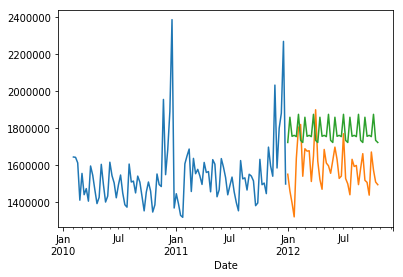

In [40]:
# Make predictions, plot them, get RMSE
# /scrub/
holt_winter = sm.tsa.api.ExponentialSmoothing(train, seasonal_periods=7, trend='add', seasonal='add').fit()
yhat_holt_winter = holt_winter.forecast(len(test))
plot_predictions(yhat_holt_winter)
calculate_rmse(yhat_holt_winter)

132537.0609841047

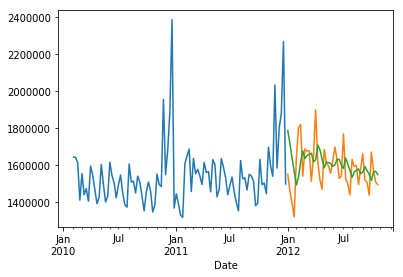

In [41]:
# Make rolling predictions, plot them, get RMSE
# /scrub/
yhat_holt_winter_rolling = make_predictions_rolling(
    lambda train: sm.tsa.api.ExponentialSmoothing(train).fit(smoothing_level=.3).forecast(1)[0]
)
plot_predictions(yhat_holt_winter_rolling)
calculate_rmse(yhat_holt_winter_rolling)

## Method 7: ARIMA

A very popular forecasting method is **ARIMA**, which stands for **autoregressive integrated moving average.** It applies **differencing** of degree $d$ and then combines two components:

- An **autoregressive** component with order $p$ that uses the previous $p$ observations to predict the next observation.
- A **moving average** component with order $q$ that accounts for possible "random shocks" that shift the mean of the series.

The **seasonal ARIMA** takes into account seasonality (like Holt's Winter method did).

#### ARIMA Model

/Users/gGandenberger/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


489261.9105214533

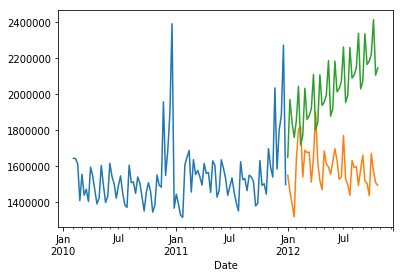

In [42]:
# Make predictions, plot them, get RMSE
# /scrub/
sarima = sm.tsa.api.statespace.SARIMAX(train, order=(2, 1, 4), seasonal_order=(0, 1, 1, 7)).fit()
yhat_sarima = sarima.forecast(len(test))
plot_predictions(yhat_sarima)
calculate_rmse(yhat_sarima)

145166.69381444066

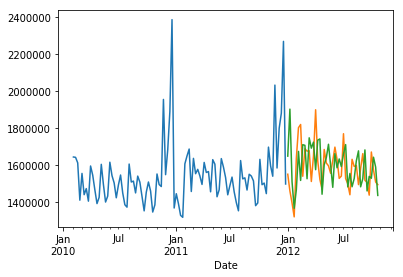

In [43]:
# Make rolling predictions, plot them, get RMSE
# /scrub/
yhat_sarima_rolling = make_predictions_rolling(
    lambda train: (
        sm.tsa.api.statespace.SARIMAX(train, order=(2, 1, 4), seasonal_order=(0, 1, 1, 7))
        .fit(smoothing_level=.3).forecast(1)[0]
    )
)
plot_predictions(yhat_sarima_rolling)
calculate_rmse(yhat_sarima_rolling)

# **Bonus:** Facebook Prophet

Prophet is a library from Facebook that promises to make fitting time series models easy. Let's give it a try.

In [44]:
!pip install fbprophet

    100% |████████████████████████████████| 2.9MB 3.0MB/s 
    100% |████████████████████████████████| 52.1MB 861kB/s 
  Running setup.py bdist_wheel for fbprophet ... error
  Complete output from command /Users/gGandenberger/anaconda3/envs/py37/bin/python -u -c "import setuptools, tokenize;__file__='/private/var/folders/x6/s99wkztn2jg30b34039zx1j40000gq/T/pip-install-mgntcluj/fbprophet/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /private/var/folders/x6/s99wkztn2jg30b34039zx1j40000gq/T/pip-wheel-k7gbtl26 --python-tag cp37:
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib
  creating build/lib/fbprophet
  creating build/lib/fbprophet/stan_model
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "/private/var/folders/x6/s99wkztn2jg30b34039zx1j40000gq/T/pip-install-mgntcluj/fbprophet/setup.py", line 1

In [45]:
from fbprophet import Prophet

In [46]:
m_train = pd.DataFrame(train).reset_index()
m_train.columns = ['ds', 'y']

In [47]:
m = Prophet(yearly_seasonality=True)
m.fit(m_train)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [48]:
future = m.make_future_dataframe(len(test)*7)

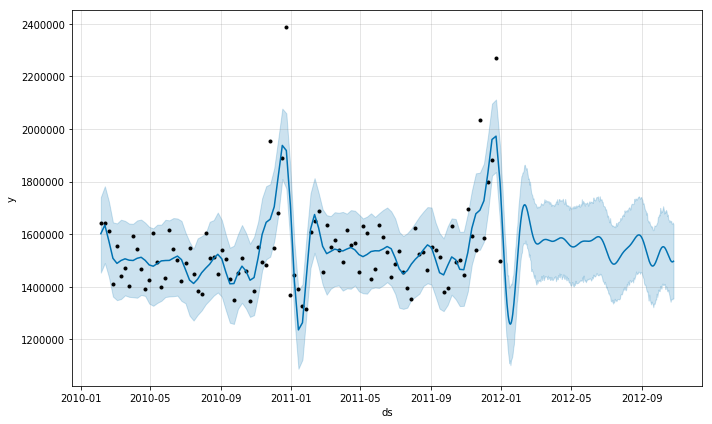

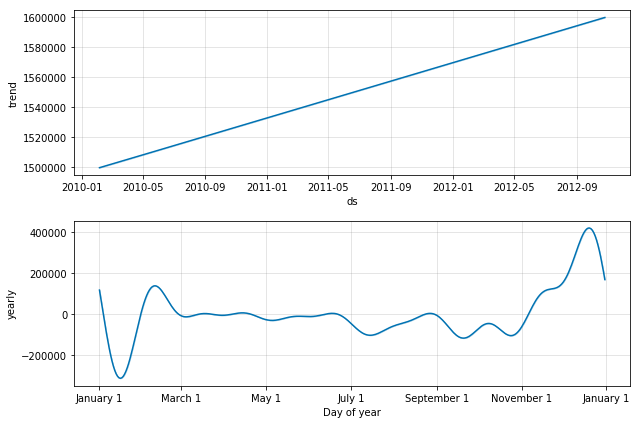

In [49]:
forecast = m.predict(future)
m.plot(forecast)
m.plot_components(forecast);

100322.81788669102

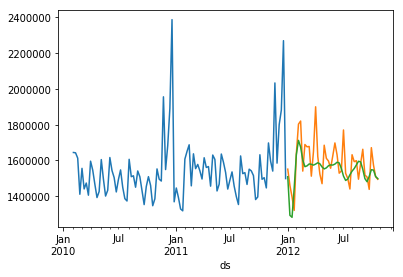

In [50]:
yhat_proph = forecast.set_index('ds').loc['2012', 'yhat']
plot_predictions(yhat_proph)
calculate_rmse(yhat_proph[::7])

Maybe not the best that a skilled time series forecaster could do, but not bad at all out of the box.

# **Bonus:** Adapting standard machine learning models for time series data.

Time series Kaggle competitions are usually won using `xgboost`, whch is a tree-based method not designed for time series at all.

Here is a quick example using a different tree-based method (a random forest) to illustrate this approach.

In [51]:
store1_data = store1.groupby(store1.index).agg({'Weekly_Sales': sum, 'IsHoliday': max})

In [52]:
store1_data.loc[:, 'month'] = store1_data.index.month
store1_data.loc[:, 'day'] = store1_data.index.day
store1_data.loc[:, 'year'] = store1_data.index.year

In [53]:
store1_data = pd.get_dummies(store1_data, columns=['month', 'day']).drop(['month_2', 'day_1'], axis=1)

In [54]:
train = store1_data.loc['2010':'2011', :]
test = store1_data.loc['2012', :]
X_train = train.iloc[:, 1:]
X_test = test.iloc[:, 1:]
y_train = train.loc[:, 'Weekly_Sales']
y_test = test.loc[:, 'Weekly_Sales']

In [55]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

/Users/gGandenberger/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [56]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

107825.1037864019

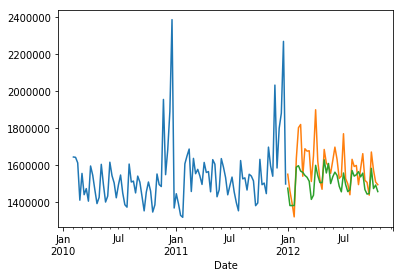

In [57]:
ax = y_train.plot()
y_test.plot(ax=ax)
pd.Series(y_pred, index=test.index).plot(ax=ax);

You could also use as features various descriptive statistics for sales from the corresponding month in the previous year, for instance. For rolling predictions, you could use various descriptive statistics over different sizes of preceding windows.

See Kaggle competition forums for past time series forecasts (such as [this one](https://www.kaggle.com/c/rossmann-store-sales)) for examples and discussion.